In [10]:
import sys
import numpy as np
from galacticus.plotting.utils import *
from galacticus.io import GalacticusHDF5
from galacticus.spectralEnergyDistributions import GalacticusSED
%matplotlib inline

In [11]:
# Load Galacticus HDF5 file and initialize GalacticusHDF5 class to load Galacticus data
ifile = "/Users/amerson/Data/Galacticus_Out/v0.9.4/wfirstSED_singleTree_lightcone/galacticus.hdf5"
GH5 = GalacticusHDF5(ifile,'r')

In [12]:
# Print redshift outputs                                                                                                                                                        
print("Redshift Outputs:")
for i,z in enumerate(GH5.outputs):
    print(GH5.outputs.name[i]+": z = "+str(GH5.outputs.z[i]))

Redshift Outputs:
Output1: z = 2.0
Output2: z = 1.8
Output3: z = 1.6
Output4: z = 1.4
Output5: z = 1.2
Output6: z = 1.0


In [13]:
# Initialize class to extract Galacticus SEDs
SED = GalacticusSED(GH5,verbose=True)

In [14]:
# EXAMPLE 1: Extract example SED at z = 1.4 with S/N=10 and using galaxy velocity dispersions to 
#            approximate the widths of Gaussian emission line profiles. Assume observer-frame.
z = 1.4
zStr = GH5.getRedshiftString(z)
print zStr
name = "totalSED:observed:Gaussian_VelocityApprox:snr10.0:"+zStr
print name

z1.4000
totalSED:observed:Gaussian_VelocityApprox:snr10.0:z1.4000


In [15]:
# Set wavelength range to obtain SED over
wavelengths = np.linspace(16000,17000,1000)

In [16]:
# Build SED (use linear interpolation to get SED at specified wavelengths)
SED.buildSED(name,wavelengths,z=z,kind='linear',fill_value='extrapolate')

/Users/amerson/anaconda/lib/python2.7/site-packages/galacticus-0.1-py2.7.egg/galacticus/spectralEnergyDistributions.py:479: RuntimeWarning: invalid value encountered in divide
  baryonicSpheroidToTotalRatio = baryonicSpheroidMass/(baryonicSpheroidMass+baryonicDiskMass)
/Users/amerson/anaconda/lib/python2.7/site-packages/galacticus-0.1-py2.7.egg/galacticus/spectralEnergyDistributions.py:481: RuntimeWarning: invalid value encountered in less
  diskDominated = baryonicSpheroidToTotalRatio<0.5
/Users/amerson/anaconda/lib/python2.7/site-packages/galacticus-0.1-py2.7.egg/galacticus/spectralEnergyDistributions.py:515: RuntimeWarning: invalid value encountered in divide
  amplitude /= (sigma*np.sqrt(2.0*Pi))
/Users/amerson/anaconda/lib/python2.7/site-packages/galacticus-0.1-py2.7.egg/galacticus/spectralEnergyDistributions.py:519: RuntimeWarning: divide by zero encountered in divide
  luminosity = amplitude*np.exp(-((wavelengths-lineWavelengths)**2)/(2.0*(sigma**2)))
/Users/amerson/anaconda/lib

In [17]:
# Get SEDs for galaxies
wavelength,sed = SED.getSED()
# Print shapes of wavelengths
print wavelength.shape,sed.shape
print("Number of galaxies = "+str(sed.shape[0]))
print wavelength
print sed[:,5]

(1000,) (90, 1000)
Number of galaxies = 90
[ 16000.          16001.001001    16002.002002    16003.003003
  16004.004004    16005.00500501  16006.00600601  16007.00700701
  16008.00800801  16009.00900901  16010.01001001  16011.01101101
  16012.01201201  16013.01301301  16014.01401401  16015.01501502
  16016.01601602  16017.01701702  16018.01801802  16019.01901902
  16020.02002002  16021.02102102  16022.02202202  16023.02302302
  16024.02402402  16025.02502503  16026.02602603  16027.02702703
  16028.02802803  16029.02902903  16030.03003003  16031.03103103
  16032.03203203  16033.03303303  16034.03403403  16035.03503504
  16036.03603604  16037.03703704  16038.03803804  16039.03903904
  16040.04004004  16041.04104104  16042.04204204  16043.04304304
  16044.04404404  16045.04504505  16046.04604605  16047.04704705
  16048.04804805  16049.04904905  16050.05005005  16051.05105105
  16052.05205205  16053.05305305  16054.05405405  16055.05505506
  16056.05605606  16057.05705706  16058.05805806 

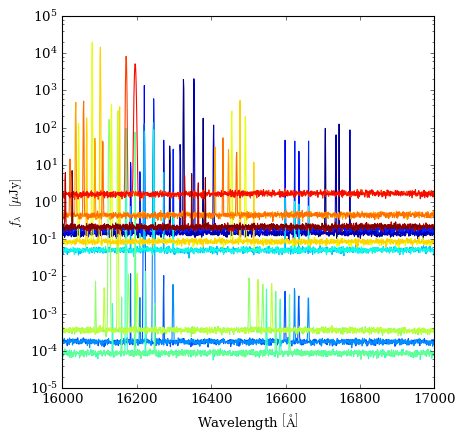

In [18]:
# Plot SEDs of first N galaxies
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111,yscale='log')
N = 20
carr = colour_array(N,cmap='jet')
for i in range(N):
    ax.plot(wavelength,sed[i,:],c=carr[i])
ax.set_xlabel("Wavelength $\left[{\\rm \AA}\\right ]$")
ax.set_ylabel("$f_{\lambda}$  $\left [{\\rm \mu Jy}\\right ]$")
ax.set_xlim(16000,17000)
show()

/Users/amerson/anaconda/lib/python2.7/site-packages/galacticus-0.1-py2.7.egg/galacticus/spectralEnergyDistributions.py:300: RuntimeWarning: invalid value encountered in log10
  self.galaxySED = np.log10(self.galaxySED)
/Users/amerson/anaconda/lib/python2.7/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


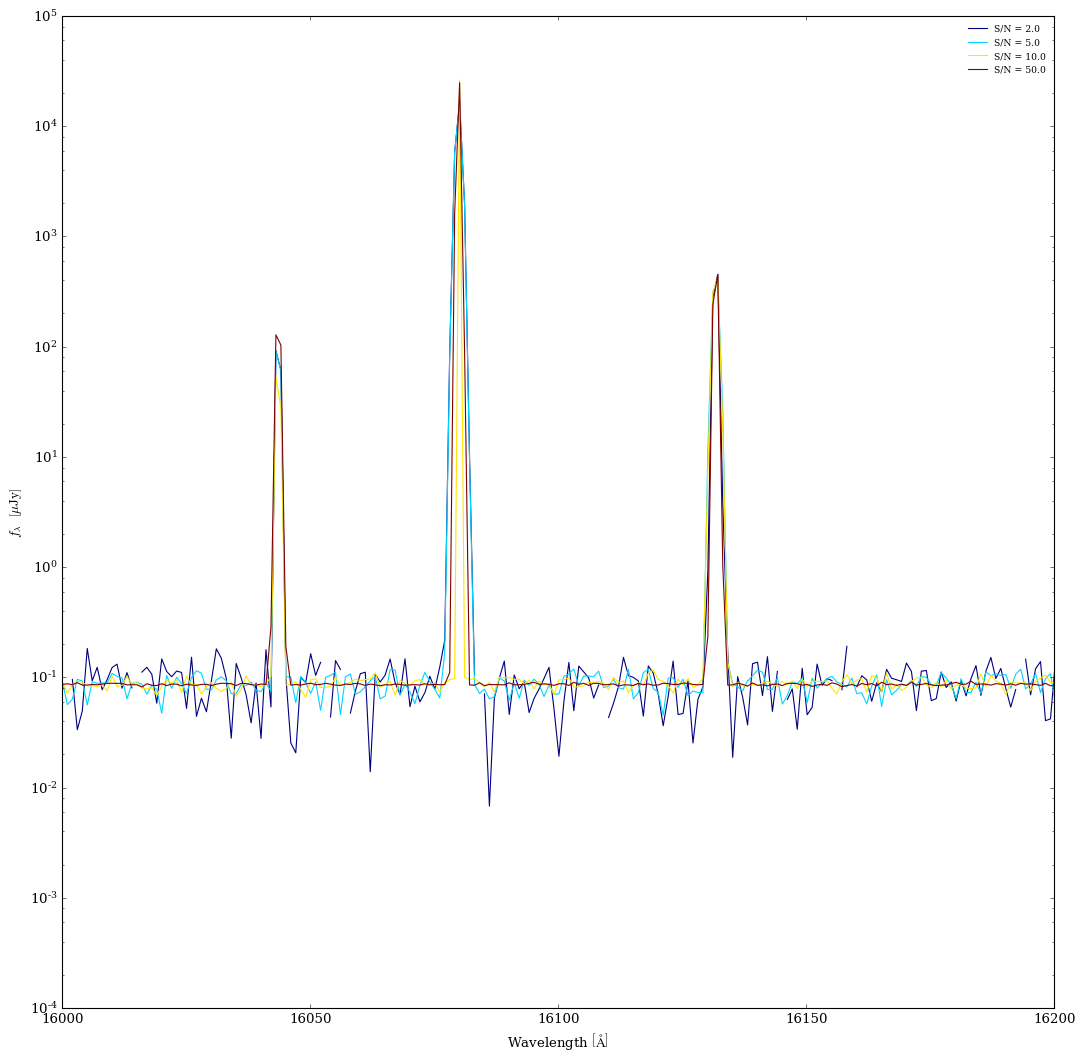

In [19]:
# EXAMPLE 2: Make plot showing different S/N ratios
z = 1.4
zStr = GH5.getRedshiftString(z)
fig = figure(figsize=(16,16))
ax = fig.add_subplot(111,yscale='log')
snRatios = "2.0 5.0 10.0 50.0".split()
carr = colour_array(len(snRatios),cmap='jet')
for i,snr in enumerate(snRatios):        
    name = "totalSED:observed:Gaussian_VelocityApprox:snr"+snr+":"+zStr
    SED.buildSED(name,wavelengths,z=z,kind='linear',fill_value='extrapolate')
    wavelength,sed = SED.getSED()
    ax.plot(wavelength,sed[12,:],c=carr[i],label="S/N = "+snr)
ax.set_xlabel("Wavelength $\left[{\\rm \AA}\\right ]$")
ax.set_ylabel("$f_{\lambda}$  $\left [{\\rm \mu Jy}\\right ]$")
ax.set_xlim(16000,16200)
Legend(ax,loc=0)
show()
    

In [20]:
# Other galaxy properties can be extracted using the GalacticusHDF5 class. For example:
z = 1.47
properties = GH5.availableDatasets(z)
#print properties

In [21]:
# Let's, for example, extract the lightcone redshifts of the galaxies from the output nearest to snapshot redshift 1.47.
import fnmatch
# Print all lightcone properties
print fnmatch.filter(properties,"lightcone*")

['lightconePositionX', 'lightconePositionY', 'lightconePositionZ', 'lightconeRedshift', 'lightconeVelocityX', 'lightconeVelocityY', 'lightconeVelocityZ']


In [22]:
# The lightcone redshift is stored as 'lightconeRedshift'. Read lightcone redshifts into numyp array.
galaxies = GH5.readGalaxies(z,props=["lightconeRedshift"])
print galaxies["lightconeRedshift"]

[ 1.48608269  1.49035311  1.47004136  1.47386963  1.46996534  1.47380196
  1.4699883   1.4738705   1.46254863  1.46627373  1.45561775  1.45916284
  1.44866056  1.45199248  1.44194083  1.44514655  1.46258345  1.46626938
  1.42982781  1.43267295  1.42398882  1.42667309  1.49533117  1.47010573
  1.47396328  1.49434648  1.49544209  1.47940921  1.48367778  1.49662526
  1.48813742  1.49209793  1.47219761  1.47574599  1.46444086  1.46779334
  1.45759117  1.46073477  1.43761577  1.44029857  1.49635038  1.4963212
  1.46421259  1.46771712  1.47963914  1.48340015  1.49445171  1.47749457
  1.48157789  1.47745326  1.48155381  1.42401874  1.42657898  1.41358011
  1.49435197  1.47025993  1.47398453  1.4703976   1.47415152  1.4245378
  1.42704499  1.46244356  1.46599843  1.49442911  1.47139248  1.47542211
  1.47122178  1.4752143   1.49582873  1.49580675  1.49600876  1.4872084
  1.49183746  1.47156609  1.4757327   1.47145414  1.47557824  1.47149411
  1.47567754  1.46392036  1.46790899  1.41996446  1.46

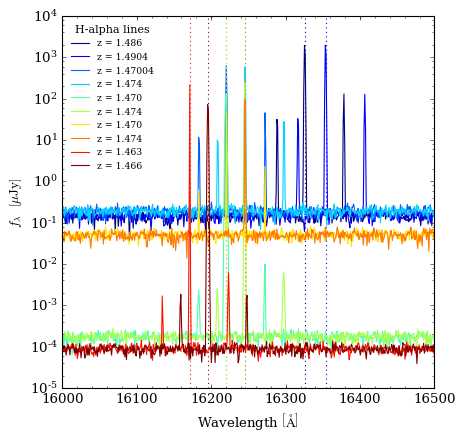

In [23]:
# EXAMPLE 3.1: Make plot showing SEDs for random sample of galaxies at different redshifts 
#              (using single snapshot directory)
z = 1.4
zStr = GH5.getRedshiftString(z)
redshifts = GH5.readGalaxies(z,props=["lightconeRedshift"])["lightconeRedshift"]
name = "totalSED:observed:Gaussian_VelocityApprox:snr5.0:"+zStr
SED.buildSED(name,wavelengths,z=z,kind='linear',fill_value='extrapolate')
wavelength,sed = SED.getSED()

galaxyIndices = np.arange(len(redshifts))
np.random.shuffle(galaxyIndices)

halpha = SED.EmissionLines.EmissionLines.getWavelength("balmerAlpha6563")
##print halpha
#halpha = 6563.0

fig = figure(figsize=(6,6))
ax = fig.add_subplot(111,yscale='log')
N = 10
carr = colour_array(N,cmap='jet')
for i in range(N):
    z = redshifts[i]
    line, = ax.plot(wavelength,sed[i,:],c=carr[i],label="z = "+sigfig(z,4))
    ax.axvline(halpha*(1.0+z),c=line.get_color(),ls=':')
ax.set_xlabel("Wavelength $\left[{\\rm \AA}\\right ]$")
ax.set_ylabel("$f_{\lambda}$  $\left [{\\rm \mu Jy}\\right ]$")
ax.set_xlim(16000,16500)
minor_ticks(ax.xaxis)
Legend(ax,loc=0,title="H-alpha lines")
show()

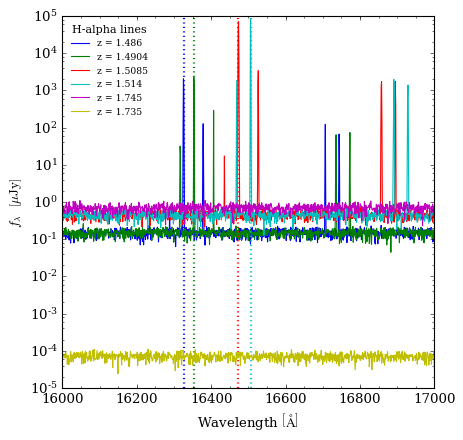

In [24]:
# EXAMPLE 3.2: Make plot showing SEDs for random sample of galaxies at different redshifts 
#              (using different snapshot directories)

halpha = SED.EmissionLines.EmissionLines.getWavelength("balmerAlpha6563")

fig = figure(figsize=(6,6))
ax = fig.add_subplot(111,yscale='log')

redshifts = [1.4,1.6,1.8]
for z in redshifts:
    zStr = GH5.getRedshiftString(z)
    redshifts = GH5.readGalaxies(z,props=["lightconeRedshift"])["lightconeRedshift"]
    name = "totalSED:observed:Gaussian_VelocityApprox:snr5.0:"+zStr
    SED.buildSED(name,wavelengths,z=z,kind='linear',fill_value='extrapolate')
    wavelength,sed = SED.getSED()

    galaxyIndices = np.arange(len(redshifts))
    np.random.shuffle(galaxyIndices)    
    N = 2
    for i in range(N):
        iz = redshifts[i]
        line, = ax.plot(wavelength,sed[i,:],label="z = "+sigfig(iz,4))
        ax.axvline(halpha*(1.0+iz),c=line.get_color(),ls=':',lw=2.0)
ax.set_xlabel("Wavelength $\left[{\\rm \AA}\\right ]$")
ax.set_ylabel("$f_{\lambda}$  $\left [{\\rm \mu Jy}\\right ]$")
ax.set_xlim(16000,17000)
minor_ticks(ax.xaxis)
Legend(ax,loc=0,title="H-alpha lines")
show()

In [25]:
# Now find the stellar masses.
print fnmatch.filter(properties,"*MassStellar")

['diskMassStellar', 'spheroidMassStellar']


In [27]:
# Stellar masses for the disk and bulge are stored separately. If the stellar mass for the total galaxy has been
# calculated it we will see a dataset "totalMassStellar". It looks like that the total stellar mass has not yet
# been computed, so we will have the compute it using the separate components.
galaxies = GH5.readGalaxies(z,props=["*MassStellar"])
# We can use wildcards to extract multiple properties
print galaxies.dtype.names
stellarMass = galaxies["diskMassStellar"] + galaxies["spheroidMassStellar"]
print stellarMass
# Note that some 'galaxies' have zero stellar mass. These entries in fact correspond to empty dark matter halos and
# so could be masked out.
mask = stellarMass > 0.0

('diskMassStellar', 'spheroidMassStellar')
[  3.36933849e+08   3.96859117e+04   3.96859117e+04   6.22191559e+07
   6.22191559e+07   3.02625614e+04   3.02625614e+04   2.29012313e+05
   2.29012313e+05   2.35699845e+05   2.35699845e+05   2.99471333e+10
   1.00493289e+09   4.41747608e+09   4.41747608e+09   2.47887632e+09
   2.47887632e+09   4.37443053e+08   0.00000000e+00   4.92882607e+10
   9.98925136e+09   1.47862192e+05   1.47862192e+05   1.89923124e+08
   6.22623037e+09   1.43822631e+09   2.54171901e+09   1.43225466e+09
   5.80277452e+08   1.88409457e+08   1.21110114e+04   1.21110114e+04
   5.34773871e+04   3.16769484e+08   3.16769484e+08   7.23514843e+08
   9.48204735e+09   9.48159409e+08   1.13861532e+09   5.91893048e+04
   2.88062382e+09   1.22548187e+05   5.08762289e+03   4.22042496e+08
   1.72670989e+08   3.38719655e+08   1.80423916e+05   1.80423916e+05
   6.84260131e+09   3.18918586e+05   1.63305165e+10   1.27028403e+04
   1.27028403e+04   8.51524706e+07   1.33021036e+10   2.1336